# LO vs. NLO simulation 

In this exercise we will get familiar with leading order (LO) and next-to-leading order (NLO) simulation. As you might know, beyond the tree level things can get messy. The NLO Feynman diagrams (diagrams with one loop) need to be taken into account and for instance the cross section calculation becomes harder. The NLO diagrams influence the experimental results as well. 

Your task this week is to analyse two datasets. One is a ttbar process (a process that produces a top quark and an anti-top quark) simulated in LO and the other is a ttbar process in NLO. These simulations have been made in the framework of CMS detector by following the circumstances of 2016 data taking. This means that we are looking at proton-proton collisions with $\sqrt{s}$ = 13 TeV center-of-mass energy. 

In this exercise we are studying jets. Jets are collimated sprays of hadrons. Since the lifetime of a top quark is very short, it decays into a jet which is then measured. The difference of LO and NLO can be seen for instance in the jet distributions.

The data for transverse momenta and pseudorapidities is structured so that each line contains the data for all jets in the same event. We want to read the data so that its a list of lists where each inner list contains all jets in the same event. An example of doing that can be seen below.

In [200]:
# An example of how to read the pt values into a 2D Python list
pts_LO = []
pts_NLO = []
etas_LO = []
etas_NLO = []

with open('tt_LO_pt2.txt', 'r') as f:
    for line in f.readlines():
        event = line.rstrip('\n').split(',')
        event = [float(i) for i in event]
        pts_LO.append(event)
                
with open('tt_LO_eta2.txt', 'r') as f:
    for line in f.readlines():
        event = line.rstrip('\n').split(',')
        event = [float(i) for i in event]
        etas_LO.append(event)
        
with open('tt_NLO_pt2.txt', 'r') as f:
    for line in f.readlines():
        event = line.rstrip('\n').split(',')
        event = [float(i) for i in event]
        pts_NLO.append(event)
        
with open('tt_NLO_eta2.txt', 'r') as f:
    for line in f.readlines():
        event = line.rstrip('\n').split(',')
        event = [float(i) for i in event]
        etas_NLO.append(event)
        
NLO_weights = pd.read_csv('tt_NLO_weights2.csv')
NLO_weights = NLO_weights['Weights']
            
print('The pT of the first jet in the first event is', round(pts_LO[0][0], 2), 'GeV')

The pT of the first jet in the first event is 63.39 GeV


### Part 1: LO and NLO jet counts

The first task is to plot the numbers of jets per event in a histogram and compare the obtained distributions for LO and NLO. Check from **Moodle** which files you should use.

NOTE: The simulated NLO events need to be weighted. Each event has a weight assigned to it which can be found in file tt_NLO_weightsX.txt. Read these and use the resulting array as input for the 'weights' argument in plt.hist. Some weights are negative. The negative weights are an artifact of the cross section calculation. There some terms get a negative weight from a fermion loop. Also normalize the histograms since there are different amounts of LO and NLO events.

Return the average number of jets per event for both datasets. Does including NLO Feynman diagrams actually make a difference in practice?

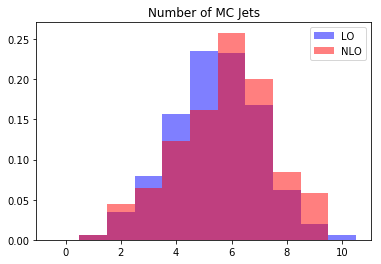

Average for LO:  5.423295454545454
Average for NLO:  5.806930693069307


In [196]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

jets_per_event_LO = []
jets_per_event_NLO = []

for event in pts_LO:
    jets_per_event_LO.append(len(event))
    
for event in pts_NLO:
    jets_per_event_NLO.append(len(event))

# Plot
bins = np.arange(0, max(jets_per_event_LO) + 1.5) - 0.5
plt.hist(jets_per_event_LO, bins=bins, color='b', density=True, alpha=0.5, label='LO')
plt.hist(jets_per_event_NLO, bins=bins, weights=NLO_weights, color='r', density=True, alpha=0.5, label='NLO')
plt.title('Number of MC Jets')
plt.legend()
plt.show()

print('Average for LO: ', np.average(jets_per_event_LO))
print('Average for NLO: ', np.average(jets_per_event_NLO))

### Part 2: Plotting pT

In this part we will take a look at the transverse momenta of individual jets in the LO dataset after doing some cuts. Accept only the jets that have $50 \textrm{ GeV} < p_T < 150 \textrm{ GeV}$ and $|\eta| < 2.1$. Use the same LO files you used in part 1.

Plot the transverse momentum for the accepted jets in a histogram. Normalize the pT distribution. Use 40 bins for the histogram. 

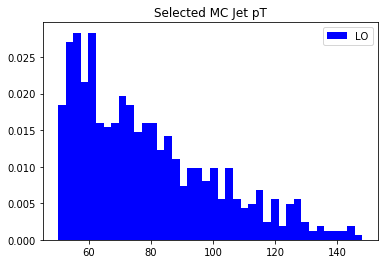

In [198]:
# Plot the jet pT for LO after cuts

pt_lower_lim = 50
pt_upper_lim = 150
eta_lim = 2.1
bin_no = 40
pt_list = pts_LO
eta_list = etas_LO

pts = []
weights = []

for i in range(len(pt_list)):
    for j in range(len(pt_list[i])):
        if pt_list[i][j] > pt_lower_lim and pt_list[i][j] < pt_upper_lim and np.abs(eta_list[i][j]) < 2.1:
            pts.append(pt_list[i][j])
       
plt.hist(pts, bins=bin_no, color='b', density=True, label='LO')

plt.title('Selected MC Jet pT')
plt.legend()
plt.show()

### Part 3: Fitting an exponential

The data you plotted should look like it could be reasonably modelled by an exponentially decaying function. Let's train curve fitting once more and try to fit an exponential curve $c_1e^{c_2x}$ to the data ($c_1$ and $c_2$ are constants).

We have used scipy.curve_fit before, but here we can be smarter than that. The easiest way to do this is to realize that an exponential curve is just a straight line after taking a logarithm. Therefore you can take the natural
logarithms of bin heights and fit a straight line $ax+b$ to them using [numpy.polyfit](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) (fitting polynomials is in general quite easy and much less frustrating than arbitrary functions). The exponential curve is then $e^be^{ax}$.

Write a function exponential fit which takes as inputs 'heights' and 'bin_edges', the first two return values given by plt.hist. It calculates the histogram centers and then fits a line to log(heights) using np.polyfit. Return the values $a$ and $e^b$ (NOT just b) **in this order**. Return two separate values, not a list. You can return multiple values by separating them with a comma.

**Submit** the function via Moodle.

In [168]:
# Write a function exponential_fit

def exponential_fit(heights, bin_edges):
    bin_centers = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)]
    par = np.polyfit(bin_centers, np.log(heights), 1)
    return par[0], np.exp(par[1])

Check by plotting that the curve created by your function fits reasonably well to the data. Return the parameters $a$ and $e^b$ for your data.

a: -0.03384934536305319
e^b: 0.19404268652284826


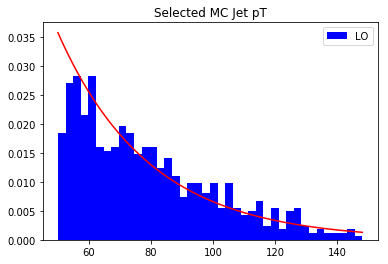

In [199]:
# Fit an exponential curve to the data. 

heights, bin_edges, patches = plt.hist(pts, bins=bin_no, color='b', density=True, label='LO')

a, eb = exponential_fit(heights, bin_edges)

print('a:', a)
print('e^b:', eb)

x = np.linspace(bin_edges[0], bin_edges[-1], 1000)

plt.plot(x, eb*np.exp(a*x), 'r')
plt.title('Selected MC Jet pT')
plt.legend()
plt.show()